In [1]:
#IMPORTS

#File IO
import os
import glob

#Data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn.functional as F
from torch.amp import GradScaler, autocast
from segmentation_models_pytorch import Unet

#Scikit learn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, r2_score

#Misc
from tqdm import tqdm


In [2]:
#HYPERPARMETERS

train_proportion = .8
val_proportion = .1

batch_size = 128
learning_rate = .00002
num_epochs = 100
loss_weights = (1.0, 1.0, .01, .01)

In [3]:
#LOAD DATASET

dataset = torch.load("dataset.pt", weights_only=False)

In [4]:
#CREATE DATALOADERS

train_size = int(train_proportion * len(dataset))
val_size = int(val_proportion * len(dataset))
test_size = len(dataset) - train_size - val_size

generator = torch.Generator().manual_seed(1)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
#CREATE MODEL

class MultiTaskV3(nn.Module):
    def __init__(self):
        super().__init__()

        self.cloud_mask_net = Unet(
            encoder_name='resnet34',
            in_channels=64,
            classes=1,
        )

        self.cloud_phase_net = Unet(
            encoder_name='resnet34',
            in_channels=64,
            classes=15,
        )
        self.cod_net = Unet(
            encoder_name='resnet34',
            in_channels=64,
            classes=15,
        )
        self.cps_net = Unet(
            encoder_name='resnet34',
            in_channels=64,
            classes=15,
        )

        self.conv0 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, padding=1)
        self.conv1 = nn.Conv2d(in_channels=16, out_channels=5, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1)


    def forward(self, x):
        x = F.relu(self.conv0(x))
        cloud_mask_pred = self.cloud_mask_net(x)
        cloud_phase_pred = self.cloud_phase_net(x)
        cod_pred = self.cod_net(x)
        cps_pred = self.cps_net(x)

        cloud_phase_pred = torch.cat([cloud_mask_pred, cloud_phase_pred], dim=1)
        cod_pred = torch.cat([cloud_mask_pred, cod_pred], dim=1)
        cps_pred = torch.cat([cloud_mask_pred, cps_pred], dim=1)

        cloud_phase_pred = F.relu(self.conv1(cloud_phase_pred))
        cod_pred = F.relu(self.conv2(cod_pred))
        cps_pred = F.relu(self.conv3(cps_pred))

        return cloud_mask_pred, cloud_phase_pred, cod_pred, cps_pred



In [6]:
#FINAL SETUP

dev_str = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(dev_str)
model = MultiTaskV3().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
scaler = GradScaler(device = device)

def unpack_labels(labels):
    return (
        labels[:, 0:1, :, :],             # cloud_mask → [B, H, W]
        labels[:, 1, :, :].long(),        # cloud_phase → [B, H, W]
        labels[:, 2:3, :, :],             # cod → [B, 1, H, W]
        labels[:, 3:4, :, :]              # cps → [B, 1, H, W]
    )


train_mask_losses, train_phase_losses, train_cod_losses, train_cps_losses, train_all_losses = [], [], [], [], []
val_mask_losses, val_phase_losses, val_cod_losses, val_cps_losses, val_all_losses = [], [], [], [], []

train_mask_acc, train_phase_acc, train_cod_r2, train_cps_r2 = [], [], [], []
val_mask_acc, val_phase_acc, val_cod_r2, val_cps_r2 = [], [], [], []

In [7]:
#TRAIN and EVALUATE FUNCTIONS

def train(model, train_loader, loss_weights=(1,1,1,1)):
    model.train()

    total_instances = 0 # Count number of instances in the epoch
    total_loss = total_loss_mask = total_loss_phase = total_loss_cod = total_loss_cps = 0 # Total loss and sublosses
    mask_correct = phase_correct = 0 # Number of correct guesses for cloud_mask and cloud_phase
    cod_preds, cod_labels = [], [] # Cod labels and predictions for calculating r2 
    cps_preds, cps_labels = [], [] # Cps labels and predictions for calculating r2

    for inputs, labels in tqdm(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        cloud_mask_target, cloud_phase_target, cod_target, cps_target = unpack_labels(labels) # Get individual targets

        optimizer.zero_grad()
        B, _, H, W = labels.shape
        total_instances += (B * H * W) # Count instances in batch
        
        with autocast(device_type=dev_str):
            preds = model(inputs) # Model predictions

            # Loss in batch
            loss_mask = nn.BCEWithLogitsLoss()(preds[0], cloud_mask_target)
            loss_phase = nn.CrossEntropyLoss()(preds[1], cloud_phase_target)
            loss_cod = nn.MSELoss()(preds[2], cod_target)
            loss_cps = nn.MSELoss()(preds[3], cps_target)
            total_batch_loss = (
                loss_weights[0] * loss_mask +
                loss_weights[1] * loss_phase +
                loss_weights[2] * loss_cod +
                loss_weights[3] * loss_cps
            )

        # Get correct guesses for mask and phase
        mask_preds = (torch.sigmoid(preds[0]) > 0.5).long()
        mask_correct += (mask_preds == cloud_mask_target).sum().item()
        phase_preds = torch.argmax(preds[1], dim=1)
        phase_correct += (phase_preds == cloud_phase_target).sum().item()

        # Get predicted and actual cod and cps
        cod_preds.append(preds[2].cpu().detach().numpy())
        cod_labels.append(cod_target.cpu().numpy())
        cps_preds.append(preds[3].cpu().detach().numpy())
        cps_labels.append(cps_target.cpu().numpy())
            

        # Update model
        scaler.scale(total_batch_loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Loss in epoch
        total_loss += total_batch_loss.item()
        total_loss_mask += loss_mask.item()
        total_loss_phase += loss_phase.item()
        total_loss_cod += loss_cod.item()
        total_loss_cps += loss_cps.item()

    # ------------------------------------ BATCH LOOP END -------------------------------------------------------------

    #Accuracy for mask and phase
    mask_accuracy = mask_correct/total_instances
    phase_accuracy = phase_correct/total_instances

    #Cod R2
    cod_preds = np.concatenate(cod_preds).ravel()
    cod_labels = np.concatenate(cod_labels).ravel()
    cod_r2 = r2_score(cod_labels, cod_preds)

    #Cps R2
    cps_preds = np.concatenate(cps_preds).ravel()
    cps_labels = np.concatenate(cps_labels).ravel()
    cps_r2 = r2_score(cps_labels, cps_preds)

    return {
        'loss_total': total_loss / len(train_loader),
        'loss_mask': total_loss_mask / len(train_loader),
        'loss_phase': total_loss_phase / len(train_loader),
        'loss_cod': total_loss_cod / len(train_loader),
        'loss_cps': total_loss_cps / len(train_loader),
        'acc_mask': mask_accuracy,
        'acc_phase': phase_accuracy,
        'r2_cod': cod_r2,
        'r2_cps': cps_r2
    }



def eval(model, val_loader, loss_weights=(1,1,1,1)):
    model.eval()

    total_instances = 0 # Count number of instances in the epoch
    total_loss = total_loss_mask = total_loss_phase = total_loss_cod = total_loss_cps = 0 # Total loss and sublosses
    mask_correct = phase_correct = 0 # Number of correct guesses for cloud_mask and cloud_phase
    cod_preds, cod_labels = [], [] # Cod labels and predictions for calculating r2 
    cps_preds, cps_labels = [], [] # Cps labels and predictions for calculating r2

    for inputs, labels in (val_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        cloud_mask_target, cloud_phase_target, cod_target, cps_target = unpack_labels(labels) # Get individual targets

        B, _, H, W = labels.shape
        total_instances += (B * H * W) # Count instances in batch
        
        
        with torch.no_grad(), autocast(device_type=dev_str):
            preds = model(inputs) # Model predictions

            # Loss in batch
            loss_mask = nn.BCEWithLogitsLoss()(preds[0], cloud_mask_target)
            loss_phase = nn.CrossEntropyLoss()(preds[1], cloud_phase_target)
            loss_cod = nn.MSELoss()(preds[2], cod_target)
            loss_cps = nn.MSELoss()(preds[3], cps_target)
            total_batch_loss = (
                loss_weights[0] * loss_mask +
                loss_weights[1] * loss_phase +
                loss_weights[2] * loss_cod +
                loss_weights[3] * loss_cps
            )

        # Get correct guesses for mask and phase
        mask_preds = (torch.sigmoid(preds[0]) > 0.5).long()
        mask_correct += (mask_preds == cloud_mask_target).sum().item()
        phase_preds = torch.argmax(preds[1], dim=1)
        phase_correct += (phase_preds == cloud_phase_target).sum().item()

        # Get predicted and actual cod and cps
        cod_preds.append(preds[2].cpu().detach().numpy())
        cod_labels.append(cod_target.cpu().numpy())
        cps_preds.append(preds[3].cpu().detach().numpy())
        cps_labels.append(cps_target.cpu().numpy())
            
        # Loss in epoch
        total_loss += total_batch_loss.item()
        total_loss_mask += loss_mask.item()
        total_loss_phase += loss_phase.item()
        total_loss_cod += loss_cod.item()
        total_loss_cps += loss_cps.item()

    # ------------------------------------ BATCH LOOP END -------------------------------------------------------------

    #Accuracy for mask and phase
    mask_accuracy = mask_correct/total_instances
    phase_accuracy = phase_correct/total_instances

    #Cod R2
    cod_preds = np.concatenate(cod_preds).ravel()
    cod_labels = np.concatenate(cod_labels).ravel()
    cod_r2 = r2_score(cod_labels, cod_preds)

    #Cps R2
    cps_preds = np.concatenate(cps_preds).ravel()
    cps_labels = np.concatenate(cps_labels).ravel()
    cps_r2 = r2_score(cps_labels, cps_preds)

    return {
        'loss_total': total_loss / len(val_loader),
        'loss_mask': total_loss_mask / len(val_loader),
        'loss_phase': total_loss_phase / len(val_loader),
        'loss_cod': total_loss_cod / len(val_loader),
        'loss_cps': total_loss_cps / len(val_loader),
        'acc_mask': mask_accuracy,
        'acc_phase': phase_accuracy,
        'r2_cod': cod_r2,
        'r2_cps': cps_r2
    }

In [8]:
#TRAIN MODEL

for e in range(1, num_epochs+1):
    train_results = train(model, train_loader, loss_weights = loss_weights)
    val_results = eval(model, val_loader, loss_weights = loss_weights)
    
    train_mask_losses.append(train_results['loss_mask'])
    train_phase_losses.append(train_results['loss_phase'])
    train_cod_losses.append(train_results['loss_cod'])
    train_cps_losses.append(train_results['loss_cps'])
    train_all_losses.append(train_results['loss_total'])

    train_mask_acc.append(train_results['acc_mask'])
    train_phase_acc.append(train_results['acc_phase'])
    train_cod_r2.append(train_results['r2_cod'])
    train_cps_r2.append(train_results['r2_cps'])

    val_mask_losses.append(val_results['loss_mask'])
    val_phase_losses.append(val_results['loss_phase'])
    val_cod_losses.append(val_results['loss_cod'])
    val_cps_losses.append(val_results['loss_cps'])
    val_all_losses.append(val_results['loss_total'])

    val_mask_acc.append(val_results['acc_mask'])
    val_phase_acc.append(val_results['acc_phase'])
    val_cod_r2.append(val_results['r2_cod'])
    val_cps_r2.append(val_results['r2_cps'])

    print(f"Epoch: {e} | Train Loss: {train_results['loss_total']:.4f} | Val Loss: {val_results['loss_total']:.4f} | Val Mask: {val_results['acc_mask']:.4f} | Val Phase: {val_results['acc_phase']:.4f} | Val Cod: {val_results['r2_cod']:.4f} | Val Cps: {val_results['r2_cps']:.4f}")
    

100%|██████████| 94/94 [00:30<00:00,  3.11it/s]


Epoch: 1 | Train Loss: 4.7957 | Val Loss: 4.6642 | Val Mask: 0.7694 | Val Phase: 0.5225 | Val Cod: -0.1855 | Val Cps: -0.8651


100%|██████████| 94/94 [00:26<00:00,  3.53it/s]


Epoch: 2 | Train Loss: 4.1923 | Val Loss: 4.2915 | Val Mask: 0.8831 | Val Phase: 0.6295 | Val Cod: -0.1833 | Val Cps: -0.8300


100%|██████████| 94/94 [00:26<00:00,  3.58it/s]


Epoch: 3 | Train Loss: 3.7851 | Val Loss: 4.1833 | Val Mask: 0.8201 | Val Phase: 0.4934 | Val Cod: -0.1940 | Val Cps: -0.5793


100%|██████████| 94/94 [00:26<00:00,  3.58it/s]


Epoch: 4 | Train Loss: 3.4118 | Val Loss: 3.8234 | Val Mask: 0.8059 | Val Phase: 0.6226 | Val Cod: -0.3475 | Val Cps: -0.3443


100%|██████████| 94/94 [00:26<00:00,  3.58it/s]


Epoch: 5 | Train Loss: 3.0452 | Val Loss: 3.4298 | Val Mask: 0.8933 | Val Phase: 0.6936 | Val Cod: -0.1223 | Val Cps: -0.3281


100%|██████████| 94/94 [00:25<00:00,  3.62it/s]


Epoch: 6 | Train Loss: 2.7403 | Val Loss: 4.4223 | Val Mask: 0.8450 | Val Phase: 0.5242 | Val Cod: -0.8612 | Val Cps: -0.5996


100%|██████████| 94/94 [00:25<00:00,  3.62it/s]


Epoch: 7 | Train Loss: 2.4853 | Val Loss: 5.2081 | Val Mask: 0.8633 | Val Phase: 0.1963 | Val Cod: 0.0566 | Val Cps: -0.0433


100%|██████████| 94/94 [00:26<00:00,  3.60it/s]


Epoch: 8 | Train Loss: 2.2532 | Val Loss: 4.1082 | Val Mask: 0.9269 | Val Phase: 0.4194 | Val Cod: 0.1115 | Val Cps: -0.4354


100%|██████████| 94/94 [00:26<00:00,  3.59it/s]


Epoch: 9 | Train Loss: 2.0685 | Val Loss: 3.3063 | Val Mask: 0.9057 | Val Phase: 0.6829 | Val Cod: 0.0633 | Val Cps: -0.3265


100%|██████████| 94/94 [00:25<00:00,  3.62it/s]


Epoch: 10 | Train Loss: 1.9023 | Val Loss: 2.8634 | Val Mask: 0.9269 | Val Phase: 0.6537 | Val Cod: 0.1073 | Val Cps: 0.0988


100%|██████████| 94/94 [00:26<00:00,  3.60it/s]


Epoch: 11 | Train Loss: 1.7536 | Val Loss: 2.2697 | Val Mask: 0.9291 | Val Phase: 0.7765 | Val Cod: 0.1549 | Val Cps: 0.1558


100%|██████████| 94/94 [00:26<00:00,  3.55it/s]


Epoch: 12 | Train Loss: 1.6225 | Val Loss: 2.4779 | Val Mask: 0.8546 | Val Phase: 0.7371 | Val Cod: -0.0388 | Val Cps: 0.3373


100%|██████████| 94/94 [00:27<00:00,  3.46it/s]


Epoch: 13 | Train Loss: 1.5126 | Val Loss: 2.1309 | Val Mask: 0.8545 | Val Phase: 0.8055 | Val Cod: 0.1633 | Val Cps: 0.3675


100%|██████████| 94/94 [00:26<00:00,  3.52it/s]


Epoch: 14 | Train Loss: 1.4254 | Val Loss: 1.8594 | Val Mask: 0.9440 | Val Phase: 0.8135 | Val Cod: 0.1693 | Val Cps: 0.3721


100%|██████████| 94/94 [00:26<00:00,  3.60it/s]


Epoch: 15 | Train Loss: 1.3697 | Val Loss: 2.8081 | Val Mask: 0.9380 | Val Phase: 0.5229 | Val Cod: 0.0070 | Val Cps: 0.4080


100%|██████████| 94/94 [00:26<00:00,  3.54it/s]


Epoch: 16 | Train Loss: 1.3187 | Val Loss: 1.8474 | Val Mask: 0.9301 | Val Phase: 0.8275 | Val Cod: 0.0545 | Val Cps: 0.4064


100%|██████████| 94/94 [00:26<00:00,  3.49it/s]


Epoch: 17 | Train Loss: 1.2801 | Val Loss: 2.2567 | Val Mask: 0.9391 | Val Phase: 0.7842 | Val Cod: -0.2753 | Val Cps: 0.3591


100%|██████████| 94/94 [00:26<00:00,  3.58it/s]


Epoch: 18 | Train Loss: 1.2472 | Val Loss: 3.5668 | Val Mask: 0.8916 | Val Phase: 0.3952 | Val Cod: 0.2433 | Val Cps: 0.3377


100%|██████████| 94/94 [00:26<00:00,  3.59it/s]


Epoch: 19 | Train Loss: 1.2224 | Val Loss: 2.7072 | Val Mask: 0.7836 | Val Phase: 0.7130 | Val Cod: 0.2100 | Val Cps: 0.3507


100%|██████████| 94/94 [00:26<00:00,  3.61it/s]


Epoch: 20 | Train Loss: 1.2085 | Val Loss: 1.9363 | Val Mask: 0.9357 | Val Phase: 0.7784 | Val Cod: 0.2627 | Val Cps: 0.3539


100%|██████████| 94/94 [00:26<00:00,  3.59it/s]


Epoch: 21 | Train Loss: 1.1806 | Val Loss: 2.8076 | Val Mask: 0.8270 | Val Phase: 0.6125 | Val Cod: 0.1091 | Val Cps: 0.4395


100%|██████████| 94/94 [00:25<00:00,  3.63it/s]


Epoch: 22 | Train Loss: 1.1611 | Val Loss: 1.8480 | Val Mask: 0.9464 | Val Phase: 0.8115 | Val Cod: 0.1862 | Val Cps: 0.3584


100%|██████████| 94/94 [00:26<00:00,  3.61it/s]


Epoch: 23 | Train Loss: 1.1431 | Val Loss: 2.1133 | Val Mask: 0.9199 | Val Phase: 0.7838 | Val Cod: -0.1962 | Val Cps: 0.4594


100%|██████████| 94/94 [00:26<00:00,  3.59it/s]


Epoch: 24 | Train Loss: 1.1385 | Val Loss: 1.8167 | Val Mask: 0.9222 | Val Phase: 0.7791 | Val Cod: 0.2490 | Val Cps: 0.4347


100%|██████████| 94/94 [00:25<00:00,  3.62it/s]


Epoch: 25 | Train Loss: 1.1244 | Val Loss: 1.9092 | Val Mask: 0.9397 | Val Phase: 0.8217 | Val Cod: 0.1113 | Val Cps: 0.2872


100%|██████████| 94/94 [00:25<00:00,  3.63it/s]


Epoch: 26 | Train Loss: 1.0934 | Val Loss: 1.6073 | Val Mask: 0.9514 | Val Phase: 0.8286 | Val Cod: 0.2023 | Val Cps: 0.4723


100%|██████████| 94/94 [00:25<00:00,  3.63it/s]


Epoch: 27 | Train Loss: 1.0793 | Val Loss: 2.5282 | Val Mask: 0.8829 | Val Phase: 0.7570 | Val Cod: -0.2239 | Val Cps: 0.1523


100%|██████████| 94/94 [00:25<00:00,  3.64it/s]


Epoch: 28 | Train Loss: 1.0649 | Val Loss: 1.8365 | Val Mask: 0.9484 | Val Phase: 0.7839 | Val Cod: 0.1256 | Val Cps: 0.4029


100%|██████████| 94/94 [00:25<00:00,  3.64it/s]


Epoch: 29 | Train Loss: 1.0565 | Val Loss: 1.6875 | Val Mask: 0.9424 | Val Phase: 0.8347 | Val Cod: 0.2553 | Val Cps: 0.3733


100%|██████████| 94/94 [00:25<00:00,  3.63it/s]


Epoch: 30 | Train Loss: 1.0426 | Val Loss: 1.6328 | Val Mask: 0.9544 | Val Phase: 0.8363 | Val Cod: 0.2725 | Val Cps: 0.4056


100%|██████████| 94/94 [00:25<00:00,  3.62it/s]


Epoch: 31 | Train Loss: 1.0260 | Val Loss: 1.6383 | Val Mask: 0.9430 | Val Phase: 0.8263 | Val Cod: 0.2543 | Val Cps: 0.4501


100%|██████████| 94/94 [00:26<00:00,  3.62it/s]


Epoch: 32 | Train Loss: 1.0143 | Val Loss: 2.3422 | Val Mask: 0.9458 | Val Phase: 0.6670 | Val Cod: 0.2886 | Val Cps: 0.2270


100%|██████████| 94/94 [00:25<00:00,  3.62it/s]


Epoch: 33 | Train Loss: 1.0040 | Val Loss: 1.7439 | Val Mask: 0.9543 | Val Phase: 0.8175 | Val Cod: 0.2793 | Val Cps: 0.4187


100%|██████████| 94/94 [00:26<00:00,  3.61it/s]


Epoch: 34 | Train Loss: 1.0000 | Val Loss: 1.8798 | Val Mask: 0.9456 | Val Phase: 0.8113 | Val Cod: 0.1601 | Val Cps: 0.3661


100%|██████████| 94/94 [00:25<00:00,  3.62it/s]


Epoch: 35 | Train Loss: 0.9820 | Val Loss: 1.5910 | Val Mask: 0.9462 | Val Phase: 0.8390 | Val Cod: 0.2640 | Val Cps: 0.4641


100%|██████████| 94/94 [00:25<00:00,  3.62it/s]


Epoch: 36 | Train Loss: 0.9723 | Val Loss: 1.6784 | Val Mask: 0.9572 | Val Phase: 0.8217 | Val Cod: 0.1946 | Val Cps: 0.4519


100%|██████████| 94/94 [00:26<00:00,  3.57it/s]


Epoch: 37 | Train Loss: 0.9665 | Val Loss: 1.9745 | Val Mask: 0.9300 | Val Phase: 0.7555 | Val Cod: 0.2522 | Val Cps: 0.3357


100%|██████████| 94/94 [00:26<00:00,  3.59it/s]


Epoch: 38 | Train Loss: 0.9547 | Val Loss: 1.5023 | Val Mask: 0.9578 | Val Phase: 0.8427 | Val Cod: 0.3137 | Val Cps: 0.4630


100%|██████████| 94/94 [00:26<00:00,  3.60it/s]


Epoch: 39 | Train Loss: 0.9497 | Val Loss: 1.5435 | Val Mask: 0.9533 | Val Phase: 0.8468 | Val Cod: 0.2882 | Val Cps: 0.4367


100%|██████████| 94/94 [00:26<00:00,  3.60it/s]


Epoch: 40 | Train Loss: 0.9420 | Val Loss: 1.9078 | Val Mask: 0.9207 | Val Phase: 0.7872 | Val Cod: 0.2604 | Val Cps: 0.4399


100%|██████████| 94/94 [00:26<00:00,  3.60it/s]


Epoch: 41 | Train Loss: 0.9351 | Val Loss: 1.6093 | Val Mask: 0.9489 | Val Phase: 0.8303 | Val Cod: 0.1914 | Val Cps: 0.4785


100%|██████████| 94/94 [00:26<00:00,  3.60it/s]


Epoch: 42 | Train Loss: 0.9198 | Val Loss: 1.5657 | Val Mask: 0.9546 | Val Phase: 0.8579 | Val Cod: 0.1433 | Val Cps: 0.4533


100%|██████████| 94/94 [00:26<00:00,  3.59it/s]


Epoch: 43 | Train Loss: 0.9118 | Val Loss: 1.6587 | Val Mask: 0.9614 | Val Phase: 0.8248 | Val Cod: 0.1815 | Val Cps: 0.4946


100%|██████████| 94/94 [00:26<00:00,  3.61it/s]


Epoch: 44 | Train Loss: 0.9143 | Val Loss: 1.5335 | Val Mask: 0.9564 | Val Phase: 0.8521 | Val Cod: 0.2098 | Val Cps: 0.4707


100%|██████████| 94/94 [00:26<00:00,  3.60it/s]


Epoch: 45 | Train Loss: 0.9019 | Val Loss: 1.7716 | Val Mask: 0.9573 | Val Phase: 0.8112 | Val Cod: 0.1844 | Val Cps: 0.4757


100%|██████████| 94/94 [00:26<00:00,  3.58it/s]


Epoch: 46 | Train Loss: 0.8957 | Val Loss: 1.6729 | Val Mask: 0.9509 | Val Phase: 0.7907 | Val Cod: 0.2840 | Val Cps: 0.4701


100%|██████████| 94/94 [00:26<00:00,  3.58it/s]


Epoch: 47 | Train Loss: 0.8864 | Val Loss: 1.4943 | Val Mask: 0.9571 | Val Phase: 0.8434 | Val Cod: 0.2262 | Val Cps: 0.4942


100%|██████████| 94/94 [00:26<00:00,  3.58it/s]


Epoch: 48 | Train Loss: 0.8814 | Val Loss: 1.7413 | Val Mask: 0.9579 | Val Phase: 0.8100 | Val Cod: 0.2981 | Val Cps: 0.4245


100%|██████████| 94/94 [00:26<00:00,  3.57it/s]


Epoch: 49 | Train Loss: 0.8743 | Val Loss: 1.5107 | Val Mask: 0.9434 | Val Phase: 0.8401 | Val Cod: 0.2442 | Val Cps: 0.5052


100%|██████████| 94/94 [00:26<00:00,  3.57it/s]


Epoch: 50 | Train Loss: 0.8710 | Val Loss: 1.7042 | Val Mask: 0.9507 | Val Phase: 0.8102 | Val Cod: 0.2737 | Val Cps: 0.4870


100%|██████████| 94/94 [00:27<00:00,  3.44it/s]


Epoch: 51 | Train Loss: 0.8635 | Val Loss: 1.6203 | Val Mask: 0.9580 | Val Phase: 0.8200 | Val Cod: 0.2565 | Val Cps: 0.4272


100%|██████████| 94/94 [00:27<00:00,  3.44it/s]


Epoch: 52 | Train Loss: 0.8612 | Val Loss: 1.8963 | Val Mask: 0.9574 | Val Phase: 0.7068 | Val Cod: 0.2889 | Val Cps: 0.5025


100%|██████████| 94/94 [00:26<00:00,  3.51it/s]


Epoch: 53 | Train Loss: 0.8525 | Val Loss: 1.6141 | Val Mask: 0.9525 | Val Phase: 0.8546 | Val Cod: 0.2095 | Val Cps: 0.4090


100%|██████████| 94/94 [00:26<00:00,  3.53it/s]


Epoch: 54 | Train Loss: 0.8462 | Val Loss: 1.4579 | Val Mask: 0.9563 | Val Phase: 0.8406 | Val Cod: 0.2969 | Val Cps: 0.5148


100%|██████████| 94/94 [00:26<00:00,  3.56it/s]


Epoch: 55 | Train Loss: 0.8404 | Val Loss: 1.5281 | Val Mask: 0.9604 | Val Phase: 0.8234 | Val Cod: 0.2240 | Val Cps: 0.5053


100%|██████████| 94/94 [00:26<00:00,  3.56it/s]


Epoch: 56 | Train Loss: 0.8305 | Val Loss: 1.5383 | Val Mask: 0.9612 | Val Phase: 0.8545 | Val Cod: 0.2710 | Val Cps: 0.4229


100%|██████████| 94/94 [00:26<00:00,  3.56it/s]


Epoch: 57 | Train Loss: 0.8290 | Val Loss: 1.7179 | Val Mask: 0.9418 | Val Phase: 0.8318 | Val Cod: 0.1209 | Val Cps: 0.4079


100%|██████████| 94/94 [00:26<00:00,  3.57it/s]


Epoch: 58 | Train Loss: 0.8297 | Val Loss: 1.4230 | Val Mask: 0.9634 | Val Phase: 0.8683 | Val Cod: 0.2913 | Val Cps: 0.4583


100%|██████████| 94/94 [00:26<00:00,  3.57it/s]


Epoch: 59 | Train Loss: 0.8267 | Val Loss: 1.5416 | Val Mask: 0.9336 | Val Phase: 0.8297 | Val Cod: 0.3598 | Val Cps: 0.5092


100%|██████████| 94/94 [00:26<00:00,  3.58it/s]


Epoch: 60 | Train Loss: 0.8173 | Val Loss: 1.4621 | Val Mask: 0.9554 | Val Phase: 0.8539 | Val Cod: 0.2695 | Val Cps: 0.5002


100%|██████████| 94/94 [00:26<00:00,  3.57it/s]


Epoch: 61 | Train Loss: 0.8086 | Val Loss: 1.6659 | Val Mask: 0.9603 | Val Phase: 0.8054 | Val Cod: 0.3275 | Val Cps: 0.4673


100%|██████████| 94/94 [00:26<00:00,  3.54it/s]


Epoch: 62 | Train Loss: 0.8059 | Val Loss: 1.4292 | Val Mask: 0.9614 | Val Phase: 0.8548 | Val Cod: 0.3159 | Val Cps: 0.4739


100%|██████████| 94/94 [00:26<00:00,  3.58it/s]


Epoch: 63 | Train Loss: 0.8002 | Val Loss: 2.0927 | Val Mask: 0.9636 | Val Phase: 0.7907 | Val Cod: 0.3407 | Val Cps: 0.4226


100%|██████████| 94/94 [00:26<00:00,  3.57it/s]


Epoch: 64 | Train Loss: 0.8054 | Val Loss: 1.5049 | Val Mask: 0.9529 | Val Phase: 0.8416 | Val Cod: 0.3020 | Val Cps: 0.4890


100%|██████████| 94/94 [00:26<00:00,  3.57it/s]


Epoch: 65 | Train Loss: 0.7950 | Val Loss: 1.7458 | Val Mask: 0.9543 | Val Phase: 0.8227 | Val Cod: 0.2747 | Val Cps: 0.4577


100%|██████████| 94/94 [00:26<00:00,  3.56it/s]


Epoch: 66 | Train Loss: 0.7921 | Val Loss: 1.3899 | Val Mask: 0.9557 | Val Phase: 0.8592 | Val Cod: 0.3493 | Val Cps: 0.5042


100%|██████████| 94/94 [00:26<00:00,  3.56it/s]


Epoch: 67 | Train Loss: 0.7892 | Val Loss: 1.4703 | Val Mask: 0.9598 | Val Phase: 0.8369 | Val Cod: 0.2887 | Val Cps: 0.5003


100%|██████████| 94/94 [00:26<00:00,  3.57it/s]


Epoch: 68 | Train Loss: 0.7818 | Val Loss: 1.4958 | Val Mask: 0.9588 | Val Phase: 0.8542 | Val Cod: 0.2310 | Val Cps: 0.4914


100%|██████████| 94/94 [00:26<00:00,  3.52it/s]


Epoch: 69 | Train Loss: 0.7781 | Val Loss: 1.4558 | Val Mask: 0.9624 | Val Phase: 0.8454 | Val Cod: 0.2810 | Val Cps: 0.5063


100%|██████████| 94/94 [00:26<00:00,  3.49it/s]


Epoch: 70 | Train Loss: 0.7788 | Val Loss: 1.7848 | Val Mask: 0.9629 | Val Phase: 0.7760 | Val Cod: 0.3456 | Val Cps: 0.3557


100%|██████████| 94/94 [00:27<00:00,  3.45it/s]


Epoch: 71 | Train Loss: 0.7682 | Val Loss: 1.3575 | Val Mask: 0.9646 | Val Phase: 0.8651 | Val Cod: 0.3596 | Val Cps: 0.5085


100%|██████████| 94/94 [00:26<00:00,  3.51it/s]


Epoch: 72 | Train Loss: 0.7695 | Val Loss: 2.0268 | Val Mask: 0.9474 | Val Phase: 0.7851 | Val Cod: 0.3294 | Val Cps: 0.3828


100%|██████████| 94/94 [00:26<00:00,  3.59it/s]


Epoch: 73 | Train Loss: 0.7635 | Val Loss: 1.5870 | Val Mask: 0.9619 | Val Phase: 0.7917 | Val Cod: 0.3425 | Val Cps: 0.4805


100%|██████████| 94/94 [00:26<00:00,  3.59it/s]


Epoch: 74 | Train Loss: 0.7661 | Val Loss: 1.4514 | Val Mask: 0.9577 | Val Phase: 0.8456 | Val Cod: 0.3689 | Val Cps: 0.5161


100%|██████████| 94/94 [00:26<00:00,  3.58it/s]


Epoch: 75 | Train Loss: 0.7556 | Val Loss: 1.4324 | Val Mask: 0.9579 | Val Phase: 0.8493 | Val Cod: 0.3714 | Val Cps: 0.4879


100%|██████████| 94/94 [00:26<00:00,  3.50it/s]


Epoch: 76 | Train Loss: 0.7538 | Val Loss: 1.5169 | Val Mask: 0.9661 | Val Phase: 0.8586 | Val Cod: 0.2219 | Val Cps: 0.4583


100%|██████████| 94/94 [00:26<00:00,  3.53it/s]


Epoch: 77 | Train Loss: 0.7493 | Val Loss: 1.4859 | Val Mask: 0.9604 | Val Phase: 0.8541 | Val Cod: 0.3500 | Val Cps: 0.4828


100%|██████████| 94/94 [00:26<00:00,  3.56it/s]


Epoch: 78 | Train Loss: 0.7498 | Val Loss: 1.5212 | Val Mask: 0.9618 | Val Phase: 0.8037 | Val Cod: 0.3740 | Val Cps: 0.4970


100%|██████████| 94/94 [00:26<00:00,  3.50it/s]


Epoch: 79 | Train Loss: 0.7502 | Val Loss: 1.6465 | Val Mask: 0.9528 | Val Phase: 0.8253 | Val Cod: 0.3485 | Val Cps: 0.4955


100%|██████████| 94/94 [00:26<00:00,  3.55it/s]


Epoch: 80 | Train Loss: 0.7425 | Val Loss: 1.5198 | Val Mask: 0.9600 | Val Phase: 0.8261 | Val Cod: 0.3082 | Val Cps: 0.4939


100%|██████████| 94/94 [00:26<00:00,  3.59it/s]


Epoch: 81 | Train Loss: 0.7408 | Val Loss: 1.7810 | Val Mask: 0.9515 | Val Phase: 0.7669 | Val Cod: 0.3075 | Val Cps: 0.4727


100%|██████████| 94/94 [00:26<00:00,  3.60it/s]


Epoch: 82 | Train Loss: 0.7362 | Val Loss: 1.3139 | Val Mask: 0.9662 | Val Phase: 0.8638 | Val Cod: 0.3624 | Val Cps: 0.5355


100%|██████████| 94/94 [00:26<00:00,  3.56it/s]


Epoch: 83 | Train Loss: 0.7330 | Val Loss: 1.3800 | Val Mask: 0.9625 | Val Phase: 0.8683 | Val Cod: 0.2993 | Val Cps: 0.4947


100%|██████████| 94/94 [00:26<00:00,  3.54it/s]


Epoch: 84 | Train Loss: 0.7280 | Val Loss: 1.5655 | Val Mask: 0.9524 | Val Phase: 0.8464 | Val Cod: 0.3300 | Val Cps: 0.5094


100%|██████████| 94/94 [00:27<00:00,  3.43it/s]


Epoch: 85 | Train Loss: 0.7320 | Val Loss: 1.4180 | Val Mask: 0.9631 | Val Phase: 0.8596 | Val Cod: 0.3328 | Val Cps: 0.4658


100%|██████████| 94/94 [00:27<00:00,  3.43it/s]


Epoch: 86 | Train Loss: 0.7266 | Val Loss: 1.4627 | Val Mask: 0.9658 | Val Phase: 0.8697 | Val Cod: 0.1724 | Val Cps: 0.4924


100%|██████████| 94/94 [00:26<00:00,  3.52it/s]


Epoch: 87 | Train Loss: 0.7264 | Val Loss: 1.3316 | Val Mask: 0.9622 | Val Phase: 0.8613 | Val Cod: 0.3782 | Val Cps: 0.5270


100%|██████████| 94/94 [00:26<00:00,  3.52it/s]


Epoch: 88 | Train Loss: 0.7250 | Val Loss: 1.3446 | Val Mask: 0.9654 | Val Phase: 0.8701 | Val Cod: 0.3963 | Val Cps: 0.4830


100%|██████████| 94/94 [00:26<00:00,  3.56it/s]


Epoch: 89 | Train Loss: 0.7166 | Val Loss: 1.5010 | Val Mask: 0.9617 | Val Phase: 0.8451 | Val Cod: 0.3716 | Val Cps: 0.4984


100%|██████████| 94/94 [00:26<00:00,  3.57it/s]


Epoch: 90 | Train Loss: 0.7169 | Val Loss: 1.3581 | Val Mask: 0.9641 | Val Phase: 0.8684 | Val Cod: 0.3898 | Val Cps: 0.4916


100%|██████████| 94/94 [00:26<00:00,  3.57it/s]


Epoch: 91 | Train Loss: 0.7162 | Val Loss: 1.4109 | Val Mask: 0.9621 | Val Phase: 0.8454 | Val Cod: 0.3645 | Val Cps: 0.5132


100%|██████████| 94/94 [00:26<00:00,  3.56it/s]


Epoch: 92 | Train Loss: 0.7133 | Val Loss: 1.4559 | Val Mask: 0.9470 | Val Phase: 0.8427 | Val Cod: 0.3827 | Val Cps: 0.5143


100%|██████████| 94/94 [00:26<00:00,  3.56it/s]


Epoch: 93 | Train Loss: 0.7073 | Val Loss: 1.3593 | Val Mask: 0.9612 | Val Phase: 0.8599 | Val Cod: 0.3945 | Val Cps: 0.5067


100%|██████████| 94/94 [00:26<00:00,  3.58it/s]


Epoch: 94 | Train Loss: 0.7097 | Val Loss: 1.9679 | Val Mask: 0.9594 | Val Phase: 0.7865 | Val Cod: 0.3755 | Val Cps: 0.5181


100%|██████████| 94/94 [00:26<00:00,  3.53it/s]


Epoch: 95 | Train Loss: 0.7063 | Val Loss: 1.4195 | Val Mask: 0.9637 | Val Phase: 0.8620 | Val Cod: 0.3784 | Val Cps: 0.4822


100%|██████████| 94/94 [00:27<00:00,  3.48it/s]


Epoch: 96 | Train Loss: 0.7042 | Val Loss: 1.3489 | Val Mask: 0.9637 | Val Phase: 0.8598 | Val Cod: 0.3905 | Val Cps: 0.5040


100%|██████████| 94/94 [00:26<00:00,  3.52it/s]


Epoch: 97 | Train Loss: 0.6963 | Val Loss: 1.3196 | Val Mask: 0.9625 | Val Phase: 0.8688 | Val Cod: 0.4114 | Val Cps: 0.5115


100%|██████████| 94/94 [00:26<00:00,  3.50it/s]


Epoch: 98 | Train Loss: 0.6996 | Val Loss: 1.3183 | Val Mask: 0.9641 | Val Phase: 0.8636 | Val Cod: 0.3988 | Val Cps: 0.5137


100%|██████████| 94/94 [00:26<00:00,  3.52it/s]


Epoch: 99 | Train Loss: 0.6921 | Val Loss: 1.5082 | Val Mask: 0.9599 | Val Phase: 0.8030 | Val Cod: 0.4011 | Val Cps: 0.5259


100%|██████████| 94/94 [00:26<00:00,  3.55it/s]


Epoch: 100 | Train Loss: 0.6937 | Val Loss: 1.3344 | Val Mask: 0.9635 | Val Phase: 0.8677 | Val Cod: 0.3599 | Val Cps: 0.5393


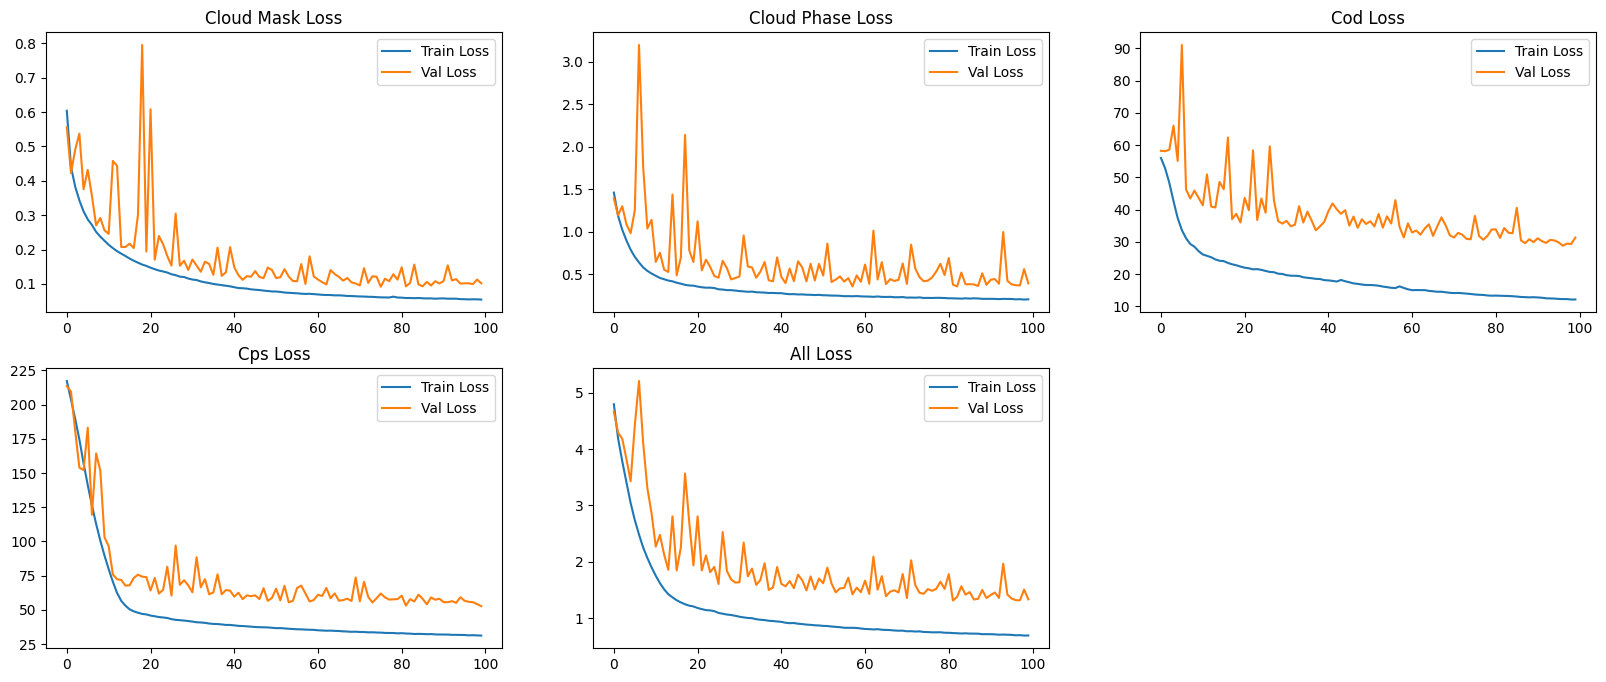

In [15]:
#PLOT LOSS

plt.figure(figsize=(20,8))

plt.subplot(2, 3, 1)
plt.plot(train_mask_losses, label='Train Loss')
plt.plot(val_mask_losses, label='Val Loss')
plt.title('Cloud Mask Loss')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(train_phase_losses, label='Train Loss')
plt.plot(val_phase_losses, label='Val Loss')
plt.title('Cloud Phase Loss')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(train_cod_losses, label='Train Loss')
plt.plot(val_cod_losses, label='Val Loss')
plt.title('Cod Loss')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(train_cps_losses, label='Train Loss')
plt.plot(val_cps_losses, label='Val Loss')
plt.title('Cps Loss')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(train_all_losses, label='Train Loss')
plt.plot(val_all_losses, label='Val Loss')
plt.title('All Loss')
plt.legend()

plt.savefig("./graphs/MultiTaskV3_loss.png")  

plt.show()

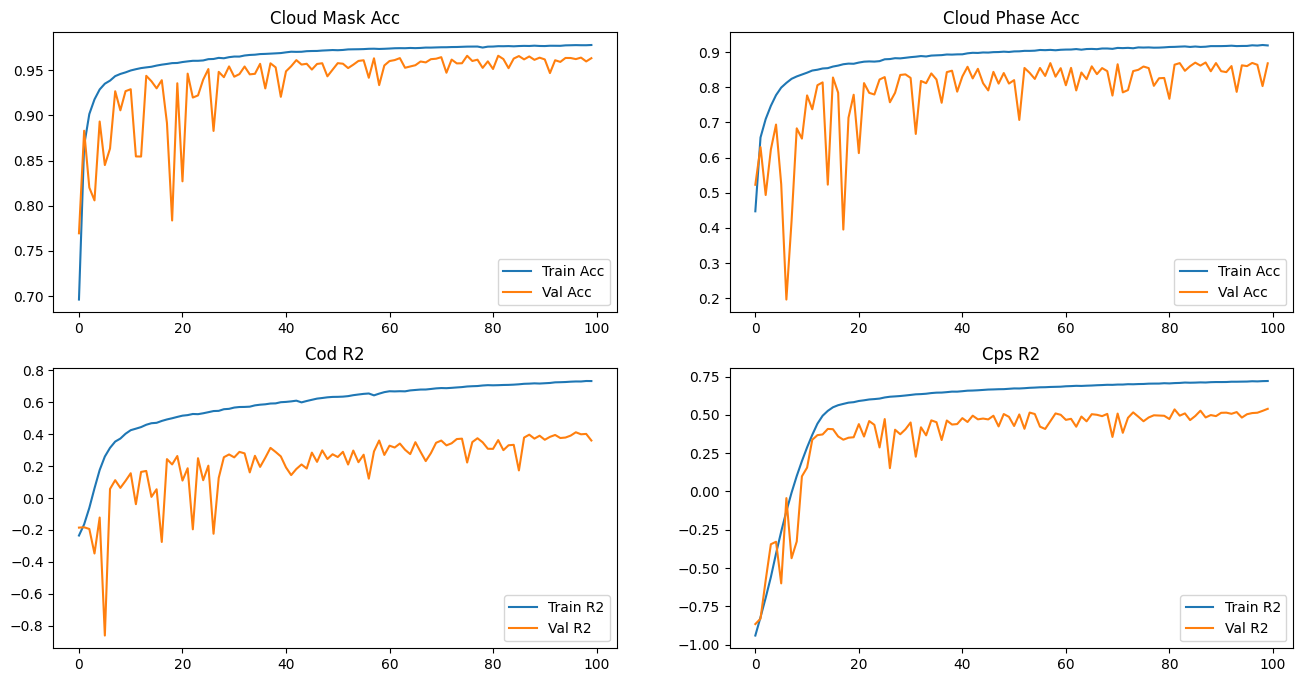

<Figure size 640x480 with 0 Axes>

In [10]:
#PLOT ACCURACY

plt.figure(figsize=(16,8))

plt.subplot(2, 2, 1)
plt.plot(train_mask_acc, label='Train Acc')
plt.plot(val_mask_acc, label='Val Acc')
plt.title('Cloud Mask Acc')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(train_phase_acc, label='Train Acc')
plt.plot(val_phase_acc, label='Val Acc')
plt.title('Cloud Phase Acc')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(train_cod_r2, label='Train R2')
plt.plot(val_cod_r2, label='Val R2')
plt.title('Cod R2')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(train_cps_r2, label='Train R2')
plt.plot(val_cps_r2, label='Val R2')
plt.title('Cps R2')
plt.legend()

plt.show()

plt.savefig("./graphs/MultiTaskV3_acc.png")  

In [11]:
# MODEL EVALUATION — CLOUD MASK

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        cloud_mask_target, _, _, _ = unpack_labels(labels)
        cloud_mask_pred, _, _, _ = model(images)

        probs = torch.sigmoid(cloud_mask_pred)
        preds = (probs > 0.5).long()

        all_preds.append(preds.cpu().numpy())
        all_labels.append(cloud_mask_target.cpu().numpy())

# Flatten predictions and labels
all_preds = np.concatenate([p.flatten() for p in all_preds])
all_labels = np.concatenate([l.flatten() for l in all_labels])

# Classification report and IoU
report = classification_report(
    all_labels, all_preds,
    labels=[0, 1],
    digits=3,
    output_dict=True,
    zero_division=0
)


# Output
print("CLOUD MASK REPORT:\n", classification_report(all_labels, all_preds, labels=[0, 1], digits=3))
print("CONFUSION MATRIX:\n", confusion_matrix(all_labels, all_preds, labels=[0, 1]))

100%|██████████| 12/12 [00:02<00:00,  5.72it/s]


CLOUD MASK REPORT:
               precision    recall  f1-score   support

           0      0.889     0.948     0.917   5103017
           1      0.986     0.969     0.977  19472983

    accuracy                          0.965  24576000
   macro avg      0.937     0.958     0.947  24576000
weighted avg      0.966     0.965     0.965  24576000

CONFUSION MATRIX:
 [[ 4836765   266252]
 [  605213 18867770]]


In [12]:
# MODEL EVALUATION — CLOUD PHASE

num_classes = 5

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        _, cloud_phase_target, _, _ = unpack_labels(labels)
        _, cloud_phase_pred, _, _ = model(images)
        preds = torch.argmax(cloud_phase_pred, dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(cloud_phase_target.cpu().numpy())
        
# Flatten predictions and labels
all_preds = np.concatenate([p.flatten() for p in all_preds])
all_labels = np.concatenate([l.flatten() for l in all_labels])

# Classification report and IoU
report = classification_report(all_labels, all_preds, digits=3, output_dict=True)
f1_scores = np.array([report[str(i)]['f1-score'] for i in range(num_classes)])
supports = np.array([report[str(i)]['support'] for i in range(num_classes)])
iou = f1_scores / (2 - f1_scores)

# Output
print("CLOUD PHASE REPORT:\n", classification_report(all_labels, all_preds, digits=3))
print("CONFUSION MATRIX:\n", confusion_matrix(all_labels, all_preds))
print("\nIOU:", iou)
print("Unweighted IoU:", np.mean(iou))
print("Weighted IoU:", np.average(iou, weights=supports))


100%|██████████| 12/12 [00:01<00:00,  6.90it/s]


CLOUD PHASE REPORT:
               precision    recall  f1-score   support

           0      0.850     0.934     0.890   3839379
           1      0.904     0.910     0.907  10990602
           2      0.773     0.905     0.833   3700196
           3      0.538     0.333     0.411   1181854
           4      0.929     0.806     0.863   4863969

    accuracy                          0.865  24576000
   macro avg      0.798     0.778     0.781  24576000
weighted avg      0.863     0.865     0.861  24576000

CONFUSION MATRIX:
 [[ 3584815   228551     6393     1867    17753]
 [  556811 10003651   267636    12456   150048]
 [    3861   272876  3347536    58792    17131]
 [    1946    86324   583148   393547   116889]
 [   69946   480058   128606   265001  3920358]]

IOU: [0.80162359 0.82959944 0.71437281 0.25891761 0.75890774]
Unweighted IoU: 0.6726842377972567
Weighted IoU: 0.7664453114747198


In [13]:
# MODEL EVALUATION — CLOUD OPTICAL DISTANCE

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device).float()
        labels = labels.to(device)

        _, _, cod_target, _ = unpack_labels(labels)
        _, _, cod_pred, _ = model(images)
        
        all_preds.append(cod_pred.cpu().numpy().reshape(-1))
        all_labels.append(cod_target.cpu().numpy().reshape(-1))

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

print("r2:", r2_score(all_labels, all_preds))
print("MSE:", mean_squared_error(all_labels, all_preds))

100%|██████████| 12/12 [00:01<00:00,  7.04it/s]


r2: 0.37953317165374756
MSE: 26.46194839477539


In [14]:
# MODEL EVALUATION — CLOUD PARTICLE SIZE

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device).float()
        labels = labels.to(device)

        _, _, _, cps_target = unpack_labels(labels)
        _, _, _, cps_pred = model(images)
        
        all_preds.append(cps_pred.cpu().numpy().reshape(-1))
        all_labels.append(cps_target.cpu().numpy().reshape(-1))

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

print("r2:", r2_score(all_labels, all_preds))
print("MSE:", mean_squared_error(all_labels, all_preds))

100%|██████████| 12/12 [00:01<00:00,  7.27it/s]


r2: 0.5571625232696533
MSE: 49.920509338378906
